<a href="https://colab.research.google.com/github/rfablet/DinAE/blob/master/notebookPyTorch_DinAE_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os
import tensorflow.keras as keras

import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from sklearn import decomposition


In [2]:
!pip install torchviz
import torchviz

In [76]:
#!mkdir /content/PythonCode
#os.mkdir('/content/PythonCode')
#os.chdir('/content/PythonCode/')
#!git clone https://github.com/CIA-Oceanix/DinAE.git
os.chdir('/content/PythonCode/DinAE')
!git pull
#import DinAE

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 1), reused 3 (delta 1), pack-reused 0
Unpacking objects: 100% (3/3), done.
From https://github.com/CIA-Oceanix/DinAE
   1008e4b..0431431  master     -> origin/master
Updating 1008e4b..0431431
Fast-forward
 dinAE_solver_torch.py | 23 ++++++++++++++++++++++-
 1 file changed, 22 insertions(+), 1 deletion(-)


In [0]:
os.mkdir('/content/PythonCode2')


In [0]:
#os.mkdir('/content/PythonCode')
#os.chdir('/content/PythonCode')
#!git clone https://github.com/CIA-Oceanix/DinAE.git
os.chdir('/content/PythonCode/DinAE')
import dinAE_solver_torch as dinAE

In [4]:
# mount gdrive
from google.colab import drive
drive.mount('/content/drive')

!ls /content/drive/My\ Drive/ResearchData/patchDataset_OcciputData.nc
import os
os.chdir('/content/drive/My Drive/')
!pwd

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'/content/drive/My Drive/ResearchData/patchDataset_OcciputData.nc'
/content/drive/My Drive


# Load and prepare data (MNIST/image data)

In [0]:
### load datasets
flagDataset = 0

if flagDataset == 0: ## MNIST
  (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
elif flagDataset == 1: ## FASHION MNIST
  (x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
#elif flagDataset == 2: ## OCCIPUT

In [0]:
# data normalization
if 1*1:
  meanTr     = np.mean(x_train[:]) 
  x_train    = x_train - meanTr
  x_test     = x_test - meanTr

  # scale wrt std
  stdTr      = np.sqrt( np.mean( x_train**2 ) )
  x_train    = x_train / stdTr
  x_test     = x_test / stdTr
  
else:
  mini = np.amin(x_train[:])
  maxi = np.amax(x_train[:])
  
  x_train = (x_train - mini ) /(maxi-mini)
  x_test  = (x_test - mini ) /(maxi-mini)

In [0]:
Wsquare = int(4)
Nsquare = int(3)

# generate missing data areas for training data
x_train_missing = np.copy(x_train).astype(float)
mask_train      = np.zeros((x_train.shape))
mask_test       = np.zeros((x_test.shape))

for ii in range(x_train.shape[0]):
  # generate mask
  mask   = np.ones((x_train.shape[1],x_train.shape[2])).astype(float)
  i_area = np.floor(np.random.uniform(Wsquare,x_train.shape[1]-Wsquare,Nsquare)).astype(int)
  j_area = np.floor(np.random.uniform(Wsquare,x_train.shape[2]-Wsquare,Nsquare)).astype(int)
  
  for nn in range(Nsquare):
    mask[i_area[nn]-Wsquare:i_area[nn]+Wsquare+1,j_area[nn]-Wsquare:j_area[nn]+Wsquare+1] = 0.
    
  # apply mask
  x_train_missing[ii,:,:] *= mask
  mask_train[ii,:,:]       = mask     
  
## generate missing data areas for test data
x_test_missing = np.copy(x_test).astype(float)

for ii in range(x_test.shape[0]):
  # generate mask
  mask   = np.ones((x_test.shape[1],x_test.shape[2])).astype(float)
  i_area = np.floor(np.random.uniform(Wsquare,x_test.shape[1]-Wsquare,Nsquare)).astype(int)
  j_area = np.floor(np.random.uniform(Wsquare,x_test.shape[2]-Wsquare,Nsquare)).astype(int)
  
  for nn in range(Nsquare):
    mask[i_area[nn]-Wsquare:i_area[nn]+Wsquare+1,j_area[nn]-Wsquare:j_area[nn]+Wsquare+1] = 0.
    
  # apply mask
  x_test_missing[ii,:,:] *= mask
  mask_test[ii,:,:]      = mask     


In [0]:
# random selection of indices for visualization
indexes_train = np.random.permutation(x_train.shape[0])
indexes_test  = np.random.permutation(x_test.shape[0])

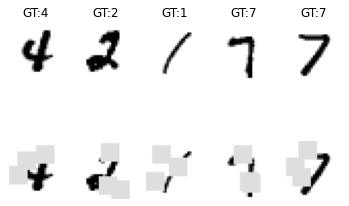

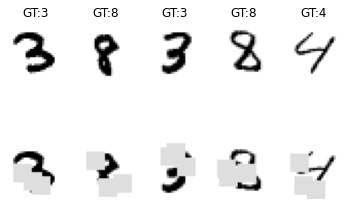

In [19]:
# visualize missing data pattern for training data
plt.figure()
for ii in range(5):
    plt.subplot(2, 5, ii + 1)
    plt.axis('off')
    plt.imshow(x_train[indexes_train[ii],:,:], cmap=plt.cm.gray_r)
    plt.title('GT:%i' %(y_train[indexes_train[ii]]))
    plt.subplot(2, 5, ii + 1+5)
    plt.axis('off')
    plt.imshow(x_train_missing[indexes_train[ii],:,:], cmap=plt.cm.gray_r)
plt.show()

# visualize missing data pattern for test data
plt.figure()
for ii in range(5):
    plt.subplot(2, 5, ii + 1)
    plt.axis('off')
    plt.imshow(x_test[indexes_test[ii],:,:], cmap=plt.cm.gray_r)
    plt.title('GT:%i' %(y_test[indexes_test[ii]]))
    plt.subplot(2, 5, ii + 1+5)
    plt.axis('off')
    plt.imshow(x_test_missing[indexes_test[ii],:,:], cmap=plt.cm.gray_r)
plt.show()

In [0]:
Ntr = 10000
Ntt = 5000

x_train = x_train[indexes_train[0:Ntr],:,:]
y_train = y_train[indexes_train[0:Ntr]]
x_train_missing = x_train_missing[indexes_train[0:Ntr],:,:]
mask_train = mask_train[indexes_train[0:Ntr],:,:]

x_test  = x_test[indexes_test[0:Ntt],:,:]
y_test  = y_test[indexes_test[0:Ntt]]
x_test_missing = x_test_missing[indexes_test[0:Ntt],:,:]
mask_test = mask_test[indexes_test[0:Ntt],:,:]


In [0]:
x_train         = x_train.reshape((x_train.shape[0],1,x_train.shape[1],x_train.shape[2]))
x_train_missing = x_train_missing.reshape((x_train_missing.shape[0],1,x_train.shape[2],x_train.shape[3]))
mask_train      = mask_train.reshape((x_train.shape[0],1,x_train.shape[2],x_train.shape[3]))

x_test         = x_test.reshape((x_test.shape[0],1,x_test.shape[1],x_test.shape[2]))
x_test_missing = x_test_missing.reshape((x_test.shape[0],1,x_test.shape[2],x_test.shape[3]))
mask_test      = mask_test.reshape((x_test.shape[0],1,x_test.shape[2],x_test.shape[3]))


# PCA Decomposition & AE artchitecture

In [0]:
DimAE      = 20#50

In [13]:
# PCA decomposition
pca              = decomposition.PCA(DimAE)
pca.fit(np.reshape(x_train,(x_train.shape[0],x_train.shape[1]*x_train.shape[2]*x_train.shape[3])))

rec_PCA_Tt       = pca.transform(np.reshape(x_test,(x_test.shape[0],x_test.shape[1]*x_test.shape[2]*x_test.shape[3])))
rec_PCA_Tt[:,DimAE:] = 0.
rec_PCA_Tt       = pca.inverse_transform(rec_PCA_Tt)
mse_PCA_Tt       = np.mean( (rec_PCA_Tt - x_test.reshape((x_test.shape[0],x_test.shape[1]*x_test.shape[2]*x_test.shape[3])))**2 )
var_Tt           = np.mean( (x_test-np.mean(x_train,axis=0))** 2 )
exp_var_PCA_Tt   = 1. - mse_PCA_Tt / var_Tt

print(".......... PCA Dim = %d"%(DimAE))
print('.... explained variance PCA (Tr) : %.2f%%'%(100.*np.cumsum(pca.explained_variance_ratio_)[DimAE-1]))
print('.... explained variance PCA (Tt) : %.2f%%'%(100.*exp_var_PCA_Tt))

# visualize PCs and associated projection
PC              = np.zeros((DimAE+1,x_test.shape[1]*x_test.shape[2]*x_test.shape[3])) * float('NaN')                        
PC[1:DimAE+1,:] = pca.components_
PC[0,:]         = pca.mean_
PC              = np.reshape(PC,(DimAE+1,x_test.shape[1],x_test.shape[2],x_test.shape[3]))

.......... PCA Dim = 20
.... explained variance PCA (Tr) : 64.54%
.... explained variance PCA (Tt) : 65.02%


In [0]:
class ResNetConv2D(torch.nn.Module):
  def __init__(self,Nblocks,dim,K,
                 kernel_size,
                 padding=0):
      super(ResNetConv2D, self).__init__()
      self.resnet = self._make_ResNet(Nblocks,dim,K,kernel_size,padding)

  def _make_ResNet(self,Nblocks,dim,K,kernel_size,padding):
      layers = []
      for kk in range(0,Nblocks):
        layers.append(torch.nn.Conv2d(dim,K*dim,kernel_size,padding=padding,bias=False))
        layers.append(torch.nn.Conv2d(K*dim,dim,kernel_size,padding=padding,bias=False))

      return torch.nn.Sequential(*layers)


  def forward(self, x):
      x = self.resnet ( x )

      return x

ResNetConv2D(
  (resnet): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): Conv2d(5, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (2): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (3): Conv2d(5, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
)
Number of trainable parameters = 248380
torch.Size([21, 1, 28, 28])


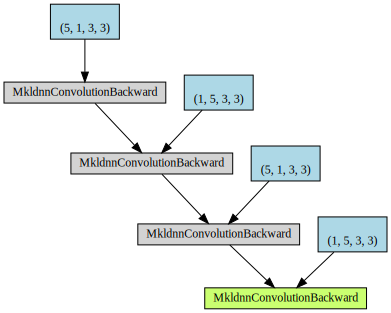

In [71]:
resnet = ResNetConv2D(2,1,5,3,1)
print(resnet)
print('Number of trainable parameters = %d'%(sum(p.numel() for p in model_AE.parameters() if p.requires_grad)))

#Model visualisation
inputs = torch.randn(21,1,28,28)
y = resnet(torch.autograd.Variable(inputs))
print(y.size())
torchviz.make_dot(y)

In [41]:
flagAEType = 1
dropout = 0.05
wl2     = 0
shapeData = x_train.shape[1:]

if flagAEType == 0: ## MLP-AE

  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.fc1 = torch.nn.Linear(shapeData[0]*shapeData[1]*shapeData[2],6*DimAE)
          self.fc2 = torch.nn.Linear(6*DimAE,2*DimAE)
          self.fc3 = torch.nn.Linear(2*DimAE,DimAE)

      def forward(self, x):
          #x = self.fc1( torch.nn.Flatten(x) )
          x = self.fc1( x.view(-1,shapeData[0]*shapeData[1]*shapeData[2]) )
          x = self.fc2( F.relu(x) )
          x = self.fc3( F.relu(x) )
          return x

  encoder = Encoder()

  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()
          self.fc1 = torch.nn.Linear(DimAE,10*DimAE)
          self.fc2 = torch.nn.Linear(10*DimAE,20*DimAE)
          self.fc3 = torch.nn.Linear(20*DimAE,shapeData[0]*shapeData[1]*shapeData[2])

      def forward(self, x):
          x = self.fc1( x )
          x = self.fc2( F.relu(x) )
          x = self.fc3( F.relu(x) )
          x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
          return x

elif flagAEType == 1: ## Conv-AE
  Wpool_i = np.floor(  (np.floor((x_train.shape[2]-2)/2)-2)/2 ).astype(int) 
  Wpool_j = np.floor(  (np.floor((x_train.shape[3]-2)/2)-2)/2 ).astype(int)

  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.conv1 = torch.nn.Conv2d(shapeData[0],DimAE,(3,3),padding=0)
          self.pool1 = torch.nn.AvgPool2d((2,2))
          self.conv2 = torch.nn.Conv2d(DimAE,2*DimAE,(3,3),padding=0)
          self.pool2 = torch.nn.AvgPool2d((2,2))
          self.conv3 = torch.nn.Conv2d(2*DimAE,4*DimAE,(Wpool_i,Wpool_j),padding=0)
          self.conv4 = torch.nn.Conv2d(4*DimAE,DimAE,(1,1),padding=0)

      def forward(self, x):
          #x = self.fc1( torch.nn.Flatten(x) )
          x = self.conv1( x )
          x = self.pool1(x)
          x = self.conv2( F.relu(x) )
          x = self.pool2(x)
          x = self.conv3( F.relu(x) )
          x = self.conv4( F.relu(x) )
          x = x.view(-1,DimAE)
          return x

  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()
          #self.conv1Tr = torch.nn.ConvTranspose2d(DimAE,1,(x_train.shape[1],x_train.shape[2]),stride=(x_train.shape[1],x_train.shape[2]),bias=False)
          self.conv1Tr = torch.nn.ConvTranspose2d(DimAE,DimAE,(int(x_train.shape[2]/2),int(x_train.shape[3]/2)),stride=(int(x_train.shape[2]/2),int(x_train.shape[3]/2)),bias=False)
          self.conv11   = torch.nn.Conv2d(DimAE,DimAE,(3,3),padding=1)
          self.conv12   = torch.nn.Conv2d(DimAE,DimAE,(3,3),padding=1)
          self.conv2Tr = torch.nn.ConvTranspose2d(DimAE,DimAE,(2,2),stride=(2,2),bias=False)
          #self.resnet  = self._make_ResNet(2,DimAE,5,3,1)
          self.resnet = dinAE.ResNetConv2D(2,DimAE,5,3,1)
          self.convF   = torch.nn.Conv2d(DimAE,1,(1,1),padding=0)
      def _make_ResNet(self,Nblocks,dim,K,kernel_size, padding):
          layers = []
          for kk in range(0,Nblocks):
            layers.append(torch.nn.Conv2d(dim,K*dim,kernel_size,padding=padding,bias=False))
            layers.append(torch.nn.Conv2d(K*dim,dim,kernel_size,padding=padding,bias=False))

          return torch.nn.Sequential(*layers)

      def forward(self, x):
          x = x.view(-1,DimAE,1,1)
          x = self.conv1Tr( x )
          x = torch.add(self.conv12( F.relu( self.conv11(x) ) ),x)
          x = torch.add(self.conv12( F.relu( self.conv11(x) ) ),x)
          x = self.conv2Tr( x )
          x = self.resnet(x)
          x = self.convF(x)

          #x = torch.add(self.conv22( F.relu( self.conv21(x) ) ),x)
          #x = torch.add(self.conv22( F.relu( self.conv21(x) ) ),x)
          #x = self.conv3( x )
          #x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
          return x

elif flagAEType == 2: ## Conv model with no use of the central point
  Wpool_i = np.floor(  (np.floor((x_train.shape[1]-2)/2)-2)/2 ).astype(int) 
  Wpool_j = np.floor(  (np.floor((x_train.shape[2]-2)/2)-2)/2 ).astype(int)

  class Encoder(torch.nn.Module):
      def __init__(self):
          super(Encoder, self).__init__()
          self.pool1 = torch.nn.AvgPool2d((2,2))
          self.conv1 = dinAE.ConstrainedConv2d(shapeData[0],shapeData[0]*DimAE,(3,3),padding=1)
          self.conv2 = torch.nn.Conv2d(shapeData[0]*DimAE,2*shapeData[0]*DimAE,(1,1),padding=0)
          self.conv3 = torch.nn.Conv2d(2*shapeData[0]*DimAE,4*shapeData[0]*DimAE,(1,1),padding=0)
          self.conv4 = torch.nn.Conv2d(4*shapeData[0]*DimAE,8*shapeData[0]*DimAE,(1,1),padding=0)
          self.conv2Tr = torch.nn.ConvTranspose2d(8*shapeData[0]*DimAE,8*shapeData[0]*DimAE,(2,2),stride=(2,2),bias=False)          
          self.conv5 = torch.nn.Conv2d(8*shapeData[0]*DimAE,16*shapeData[0]*DimAE,(3,3),padding=1)
          self.conv6 = torch.nn.Conv2d(16*shapeData[0]*DimAE,1,(3,3),padding=1)

      def forward(self, x):
          #x = self.fc1( torch.nn.Flatten(x) )
          x = self.pool1( x )
          x = self.conv1(x)
          x = self.conv2( F.relu(x) )
          x = self.conv3( F.relu(x) )
          x = self.conv4( F.relu(x) )
          x = self.conv2Tr( x )
          x = self.conv5( x )
          x = self.conv6( x )
          x = x.view(-1,shapeData[0],shapeData[1],shapeData[2])
          return x

  class Decoder(torch.nn.Module):
      def __init__(self):
          super(Decoder, self).__init__()

      def forward(self, x):
          return torch.mul(1.,x)

class Model_AE(torch.nn.Module):
    def __init__(self):
        super(Model_AE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder( x )
        x = self.decoder( x )
        return x

model_AE = Model_AE()

print(model_AE)
print('Number of trainable parameters = %d'%(sum(p.numel() for p in model_AE.parameters() if p.requires_grad)))

Model_AE(
  (encoder): Encoder(
    (conv1): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1))
    (pool1): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (conv2): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1))
    (pool2): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
    (conv3): Conv2d(40, 80, kernel_size=(5, 5), stride=(1, 1))
    (conv4): Conv2d(80, 20, kernel_size=(1, 1), stride=(1, 1))
  )
  (decoder): Decoder(
    (conv1Tr): ConvTranspose2d(20, 20, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (conv11): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv12): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2Tr): ConvTranspose2d(20, 20, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (resnet): ResNetConv2D(
      (resnet): Sequential(
        (0): Conv2d(20, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): Conv2d(100, 20, kernel_size=(3, 3), stride=(1, 1), paddi

torch.Size([21, 1, 28, 28])


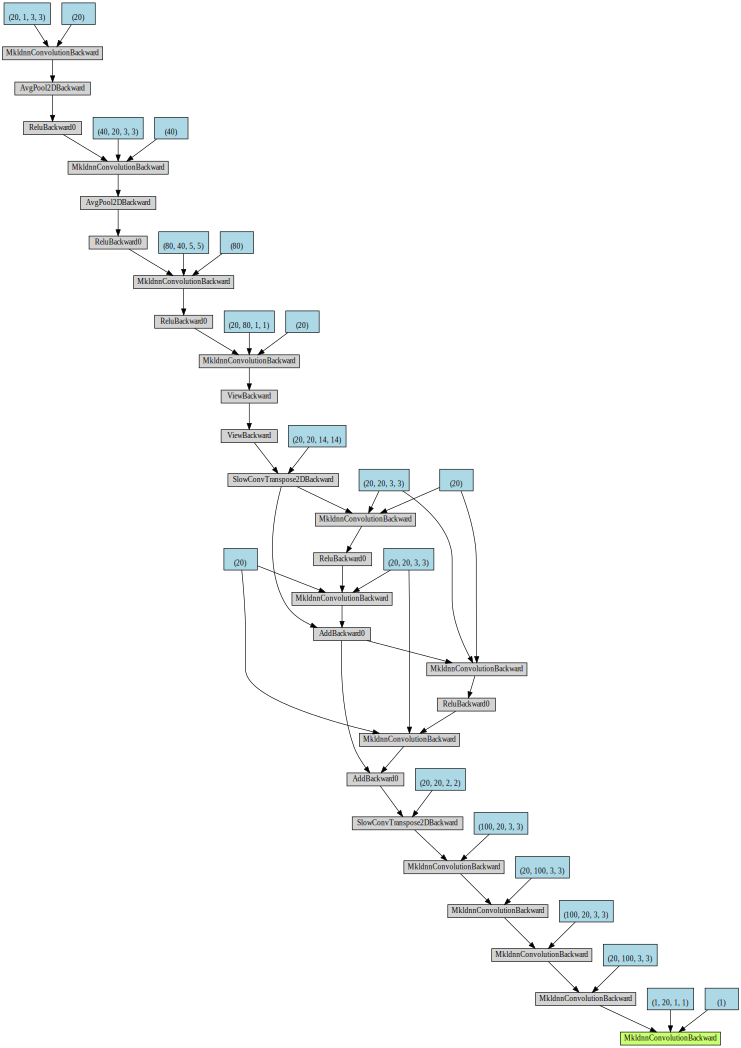

In [42]:
#Model visualisation
inputs = torch.randn(21,1,28,28)
y = model_AE(torch.autograd.Variable(inputs))
print(y.size())
torchviz.make_dot(y)

# Learning AE model

In [0]:
# Create training/test data pytorch tensors and associated  
# list of tensors (xx[n][x] to access the nth sample for the xth field)
training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True),
}

dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}

In [0]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model_AE  = model_AE.to(device)
#model_AE.resnet = model_AE.decoder.resnet.to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer        = optim.Adam(model_AE.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# mean-squared error loss
criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )

# training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_var  = 0.0

            # Iterate over data.
            for inputs_ in dataloaders[phase]:
                inputs = inputs_[0]
                inputs = inputs.to(device)
                #print(inputs.size(0))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #loss = criterion(outputs, inputs)
                    loss = torch.mean((outputs - inputs)**2)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss   += loss.item() * inputs.size(0)
                #running_expvar += torch.sum( (outputs - inputs)**2 ) / torch.sum(
            if phase == 'train':
                scheduler.step()

            epoch_loss  = running_loss / dataset_sizes[phase]
            if phase == 'train':
              epoch_nloss = epoch_loss / var_Tr
            else:
              epoch_nloss = epoch_loss / var_Tt
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} NLoss: {:.4f} '.format(
                phase, epoch_loss, epoch_nloss))
#            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [45]:
# training AE model
model_AE = train_model(model_AE, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
train Loss: 0.1761 NLoss: 0.1761 
val Loss: 0.1030 NLoss: 0.1014 

Epoch 1/4
----------
train Loss: 0.0956 NLoss: 0.0956 
val Loss: 0.0887 NLoss: 0.0873 

Epoch 2/4
----------
train Loss: 0.0862 NLoss: 0.0862 
val Loss: 0.0823 NLoss: 0.0811 

Epoch 3/4
----------
train Loss: 0.0809 NLoss: 0.0809 
val Loss: 0.0809 NLoss: 0.0797 

Epoch 4/4
----------
train Loss: 0.0776 NLoss: 0.0776 
val Loss: 0.0755 NLoss: 0.0744 

Training complete in 1m 60s
Best val loss: 0.075512


# Learning AE model from irregularly-sampled data (DinAE model)

In [0]:
# training function for dinAE
def train_model(model, optimizer, scheduler,alpha, num_epochs=25):
    since = time.time()

    alpha_MaskedLoss = alpha[0]
    alpha_GTLoss     = 1. - alpha[0]
    alpha_AE         = alpha[1]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                #rint('Learning')
                model.train()  # Set model to training mode
            else:
                #print('Evaluation')
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_loss_All     = 0.
            running_loss_R       = 0.
            running_loss_I       = 0.
            running_loss_AE      = 0.
            num_loss     = 0

            # Iterate over data.
            #for inputs_ in dataloaders[phase]:
            #    inputs = inputs_[0].to(device)
            for inputs_missing,masks,inputs_GT in dataloaders[phase]:
                inputs_missing = inputs_missing.to(device)
                masks          = masks.to(device)
                inputs_GT      = inputs_GT.to(device)
                #print(inputs.size(0))

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # need to evaluate grad/backward during the evaluation and training phase for model_AE
                with torch.set_grad_enabled(True): 
                #with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs_missing,masks)
                    #outputs = model(inputs)
                    #loss = criterion( outputs,  inputs)
                    loss_R      = torch.sum((outputs - inputs_GT)**2 * masks )
                    loss_R      = torch.mul(1.0 / torch.sum(masks),loss_R)
                    loss_I      = torch.sum((outputs - inputs_GT)**2 * (1. - masks) )
                    loss_I      = torch.mul(1.0 / torch.sum(1.-masks),loss_I)
                    loss_All    = torch.mean((outputs - inputs_GT)**2 )
                    loss_AE     = torch.mean((model.model_AE(outputs) - outputs)**2 )
                    
                    if alpha_MaskedLoss > 0.:
                        loss = torch.mul(alpha_MaskedLoss,loss_R)
                    else: 
                        loss = torch.mul(alpha_GTLoss,loss_All)
                    loss = torch.add(loss,torch.mul(alpha_AE,loss_AE))

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss             += loss.item() * inputs_missing.size(0)
                running_loss_I           += loss_I.item() * inputs_missing.size(0)
                running_loss_R           += loss_R.item() * inputs_missing.size(0)
                running_loss_All         += loss_All.item() * inputs_missing.size(0)
                running_loss_AE          += loss_AE.item() * inputs_missing.size(0)
                num_loss                 += inputs_missing.size(0)
                #running_expvar += torch.sum( (outputs - inputs)**2 ) / torch.sum(
            if phase == 'train':
                scheduler.step()

            epoch_loss       = running_loss / num_loss
            epoch_loss_All   = running_loss_All / num_loss
            epoch_loss_AE    = running_loss_AE / num_loss
            epoch_loss_I     = running_loss_I / num_loss
            epoch_loss_R     = running_loss_R / num_loss
            #epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
              epoch_nloss_All = epoch_loss_All / var_Tr
              epoch_nloss_I   = epoch_loss_I / var_Tr
              epoch_nloss_R   = epoch_loss_R / var_Tr
              epoch_nloss_AE   = loss_AE / var_Tr
            else:
              epoch_nloss_All = epoch_loss_All / var_Tt
              epoch_nloss_I   = epoch_loss_I / var_Tt
              epoch_nloss_R   = epoch_loss_R / var_Tt
              epoch_nloss_AE   = loss_AE / var_Tt

            #print('{} Loss: {:.4f} '.format(
             #   phase, epoch_loss))
            print('{} Loss: {:.4f} NLossAll: {:.4f} NLossR: {:.4f} NLossI: {:.4f} NLossAE: {:.4f}'.format(
                phase, epoch_loss,epoch_nloss_All,epoch_nloss_R,epoch_nloss_I,epoch_nloss_AE))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [0]:
# Create training/test data pytorch tensors and associated  
# list of tensors (xx[n][x] to access the nth sample for the xth field)

# no mask
#training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train),torch.add(1.0,torch.mul(0.0,torch.Tensor(mask_train))),torch.Tensor(x_train)) # create your datset
#test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test),torch.add(1.0,torch.mul(0.0,torch.Tensor(mask_test))),torch.Tensor(x_test)) # create your datset

training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_missing),torch.Tensor(mask_train),torch.Tensor(x_train)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_missing),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset

dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True),
}

dataset_sizes = {'train': len(training_dataset), 'val': len(test_dataset)}

In [0]:
#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# mean-squared error loss
#criterion = torch.nn.MSELoss()
var_Tr    = np.var( x_train )
var_Tt    = np.var( x_test )

if 1*0:
  model_AE2    = Model_AE()

if 1*1:
    alpha           = np.array([1.0,0.1])
    GradType        = 0 # Gradient computation (0: subgradient, 1: true gradient/autograd)
    OptimType       = 0 # 0: fixed-step gradient descent, 1: ConvNet_step gradient descent, 2: LSTM-based descent
    NiterProjection = 2 # Number of fixed-point iterations
    NiterGrad       = 10 # Number of gradient descent step
    
    # NiterProjection,NiterGrad: global variables
    # bug for NiterProjection = 0
    shapeData       = x_train.shape[1:]
    model_AE_GradFP = dinAE.Model_AE_GradFP(model_AE2,shapeData,NiterProjection,NiterGrad,GradType,OptimType)

    model_AE_GradFP = model_AE_GradFP.to(device)

    # create an optimizer object
    # Adam optimizer with learning rate 1e-3
    optimizer        = optim.Adam(model_AE_GradFP.parameters(), lr=1e-3)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

model_AE_GradFP = train_model(model_AE_GradFP, optimizer, exp_lr_scheduler,
                       alpha,num_epochs=5)

Epoch 0/4
----------
train Loss: 0.4034 NLossAll: 0.6161 NLossR: 1.2239 NLossI: 0.3934 NLossAE: 0.0322
val Loss: 0.1763 NLossAll: 0.3583 NLossR: 0.8782 NLossI: 0.1688 NLossAE: 0.0470

Epoch 1/4
----------
train Loss: 0.1477 NLossAll: 0.3447 NLossR: 0.8964 NLossI: 0.1438 NLossAE: 0.0475
val Loss: 0.1274 NLossAll: 0.3266 NLossR: 0.8871 NLossI: 0.1223 NLossAE: 0.0244

Epoch 2/4
----------


(1, 28, 28)

In [1]:
### Visualisation of results
### Apply model to test data

def compute_loss(outputs,inputs_GT,outputs_AE,masks,shapeData):

  # masked loss
  diff = (outputs - inputs_GT)**2 * masks
  masked_loss = torch.sum(diff.view(-1,shapeData[0]*shapeData[1]*shapeData[2]) , 1 )
  masked_loss = masked_loss / torch.sum(masks.view(-1,shapeData[0]*shapeData[1]*shapeData[2]) , 1 )

  # loss GT
  diff = (outputs - inputs_GT)**2
  loss_GT = torch.mean(diff.view(-1,shapeData[0]*shapeData[1]*shapeData[2]) , 1 )

  # loss AE
  diff = (outputs - outputs_AE)**2
  loss_AE = torch.mean(diff.view(-1,shapeData[0]*shapeData[1]*shapeData[2]) , 1 )

  return masked_loss,loss_GT,loss_AE

# apply model
outputs = []

for inputs_missing,masks,inputs_GT in dataloaders['val']:
  inputs_missing = inputs_missing.to(device)
  masks          = masks.to(device)
  inputs_GT      = inputs_GT.to(device)
  with torch.set_grad_enabled(True): 
  #with torch.set_grad_enabled(phase == 'train'):
      outputs_ = model_AE_GradFP(inputs_missing,masks)

  # MSE
  masked_loss_,loss_GT_,loss_AE_ = compute_loss(outputs_,inputs_GT,model_AE_GradFP.model_AE(outputs_),masks,shapeData)

  if len(outputs) == 0:
    outputs  = torch.mul(1.0,outputs_)
    masked_loss = masked_loss_
    loss_GT     = loss_GT_
    loss_AE     = loss_AE_
  else:
    outputs     = torch.cat((outputs,outputs_),0)
    masked_loss = torch.cat((masked_loss,masked_loss_),0)
    loss_GT     = torch.cat((loss_GT,loss_GT_),0)
    loss_AE     = torch.cat((loss_AE,loss_AE_),0)
                    
mean_masked_loss = torch.mean( masked_loss ).cpu().detach().numpy()
mean_loss_GT     = torch.mean( loss_GT ).cpu().detach().numpy()
mean_loss_AE     = torch.mean( loss_AE ).cpu().detach().numpy()

v = np.var(x_test[:,:,:])

# Visualisation
# visualize missing data pattern for test data
plt.figure()
for ii in range(5):
    plt.subplot(3, 5, ii + 1)
    plt.axis('off')
    plt.imshow(inputs_GT[ii,:,:].cpu().detach().numpy().squeeze(), cmap=plt.cm.gray_r)
    plt.title('GT')
    plt.subplot(3, 5, ii + 1+5)
    plt.axis('off')
    plt.imshow(inputs_missing[ii,:,:].cpu().detach().numpy().squeeze(), cmap=plt.cm.gray_r)
    plt.title('Obs')
    plt.subplot(3, 5, ii + 1+10)
    plt.axis('off')
    plt.imshow(outputs[ii,:,:].cpu().detach().numpy().squeeze(), cmap=plt.cm.gray_r)
    plt.title('Obs')
plt.show()

print('# Random test dataset: NLossMask: {:.4f} NLossGT: {:.4f} NLossAE: {:.4f}'.format(
      mean_masked_loss/v, mean_loss_GT/v,mean_loss_AE/v))


NameError: ignored

In [109]:
print(outputs.size())

torch.Size([896, 1, 28, 28])
